# Изучение закономерностей, определяющих успешность игр

# Цель проекта

Проект представляет из себя набор данных с информацией о продаже видеоигр.

Цель проекта: попробовать спрогнозировать продажи игр на следующий год, проверить, на каких платформах игры будут продаваться лучше. Проверить несколько гипотез и понять, какие факторы влияют на продажи.

В таблице есть данные о названии игры, платформе, дате релиза, жанре игры, продажи в разбивке по регионам - Северная Америка, Европа, Япония и остальные страны. Далее приведены оценки критиков, пользователей и возрастной рейтинг игры.

План работы над проектом:
1. Ознакомиться с данными.
2. Выполнить предобработку данных.
3. Выполнить анализ данных.
4. Проверить гипотезы.
5. Сформулировать общий вывод.

# Чтение файла и просмотр общей информации

## Импорт необходимых библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st

## Открытие датасета

In [2]:
try:
    data = pd.read_csv("/datasets/games.csv")
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

## Проверка первых 5 строк таблицы

In [3]:
data.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


## Просмотр информации о таблице

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Наблюдаю достаточно много пропусков в столбцах оценки критиков и пользователей, также много пропусков рейтинга игры.

# Предобработка данных

### Поиск явных дубликатов

In [5]:
print('Количество найденых дубликатов:', data.duplicated().sum())

Количество найденых дубликатов: 0


### Приведу названия столбцов к нижнему регистру

In [6]:
data.columns = data.columns.str.lower()

#### Замена пропусков в столбце "Имя" на "Без имени"

In [7]:
data["name"] = data["name"].fillna("no_name")

#### Удаление строк с пропусками в столбце "Год издания" и перевод столбца в формат int

In [8]:
data = data.dropna(subset = ["year_of_release"])
data["year_of_release"] = data["year_of_release"].astype(int)

#### Замена пропусков в столбце "Жанр" на "Без жанра"

In [9]:
data["genre"] = data["genre"].fillna("nogenre")

#### В столбце оценка игрока значение "tbd" заменяю на 0 и изменяю тип данных на int

In [10]:
data = data.replace('tbd', '0')
data["user_score"] = data["user_score"].astype(float)

tbd означает "To Be Determined" - т.е., оценка будет определена позже. По смыслу это ничем не отличается от пропуска.

#### Проверка пропусков и измененных форматов

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16446 non-null  object 
 1   platform         16446 non-null  object 
 2   year_of_release  16446 non-null  int64  
 3   genre            16446 non-null  object 
 4   na_sales         16446 non-null  float64
 5   eu_sales         16446 non-null  float64
 6   jp_sales         16446 non-null  float64
 7   other_sales      16446 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   float64
 10  rating           9768 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


- Остались пропуски в столбцах рейтинга игры, оценки критиков и игроков. Так мы исключаем вероятность выключить в анализ нереальные данные. Исключим их на стадии проверки гипотез.
- Пропуски в данных столбцах нет возможности заполнить, среднее или медиана нам не подойдут.


#### Заменяю пропуски в столбце возрастного рейтинга на "Без рейтинга"

In [12]:
data["rating"] = data["rating"].fillna("no_rating")

Для дальнейшего иследования нам интересен этот столбец, заменю пропуски на заглушки, чтобы в дальнейшем посмотреть на их долю.

### Выполняю подсчет суммарных продаж во всех регионах и сохраняю в отдельный столбец

In [13]:
sum_list = ["na_sales", "eu_sales", "jp_sales", "other_sales"]
data["main_sales"] = data[sum_list].sum(axis=1)

## Исследовательский анализ данных.

### Проверю, сколько игр выпускалось в разные годы

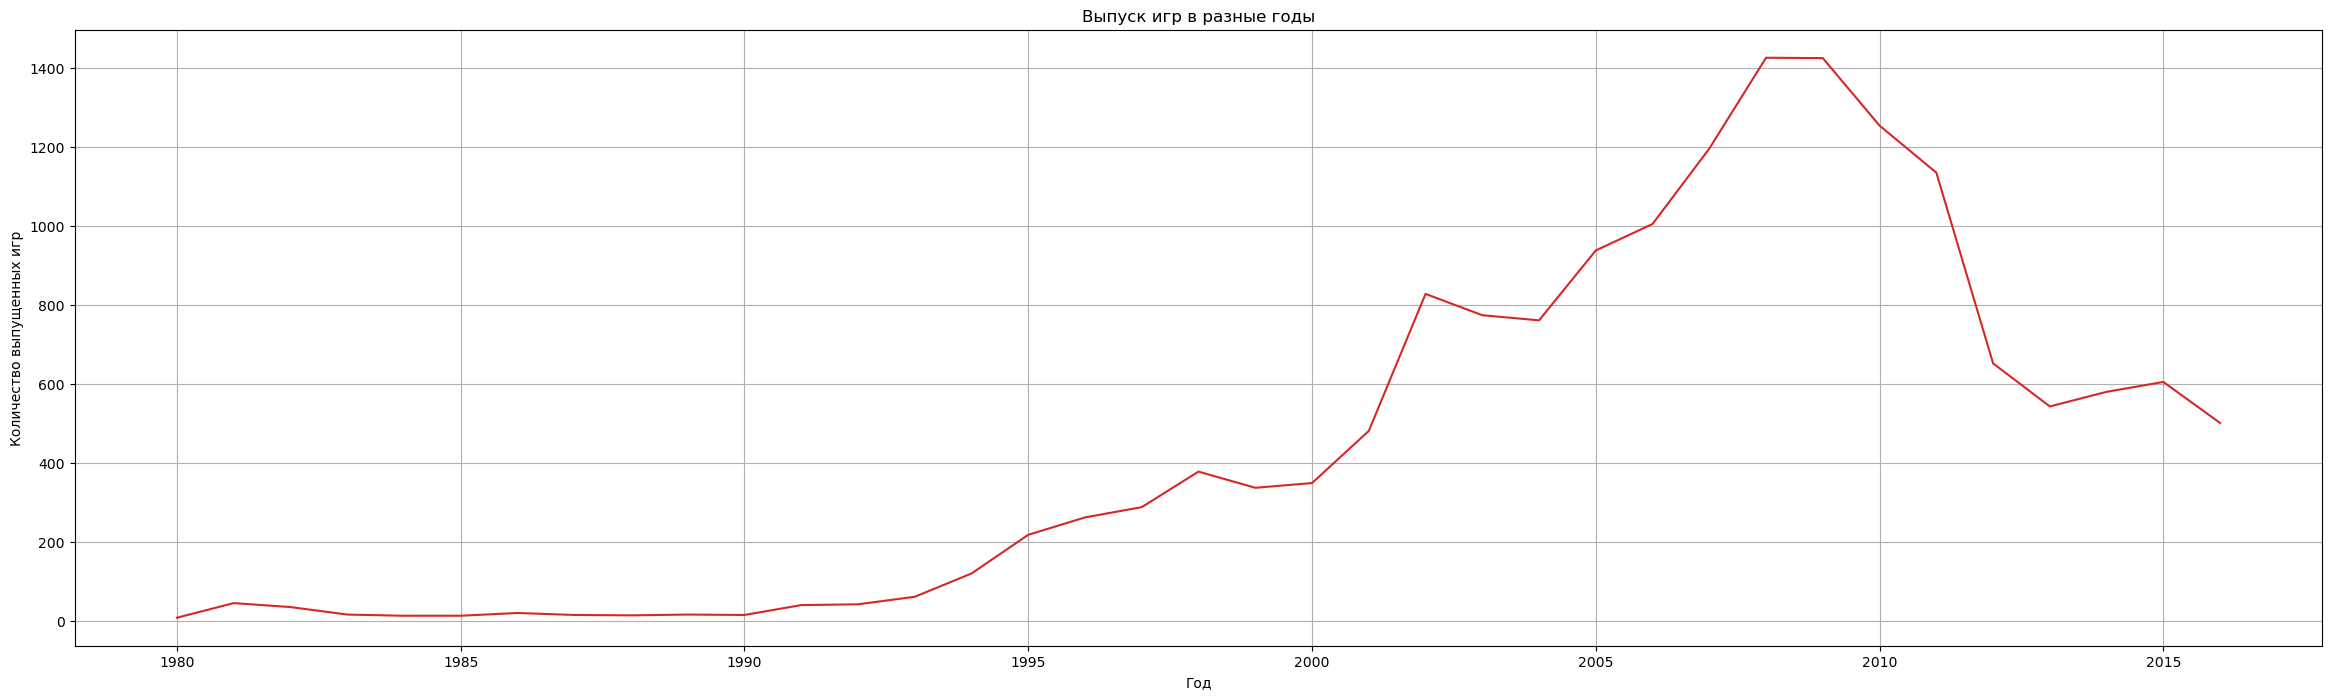

In [14]:
data.groupby('year_of_release')['name'].agg('count').plot(x = "year_of_release", figsize = (29,8), grid = True, color='tab:red')
plt.title('Выпуск игр в разные годы')
plt.xlabel("Год")
plt.ylabel("Количество выпущенных игр")
plt.show()

До 1993 года в год выпускалось менее 100 игр. Можно их не рассматривать. Больше всего игр выпускалось с 2005 по 2010 год.

### Посмотрю, как менялись продажи по платформам

#### Выберу платформы с наибольшими суммарными продажами

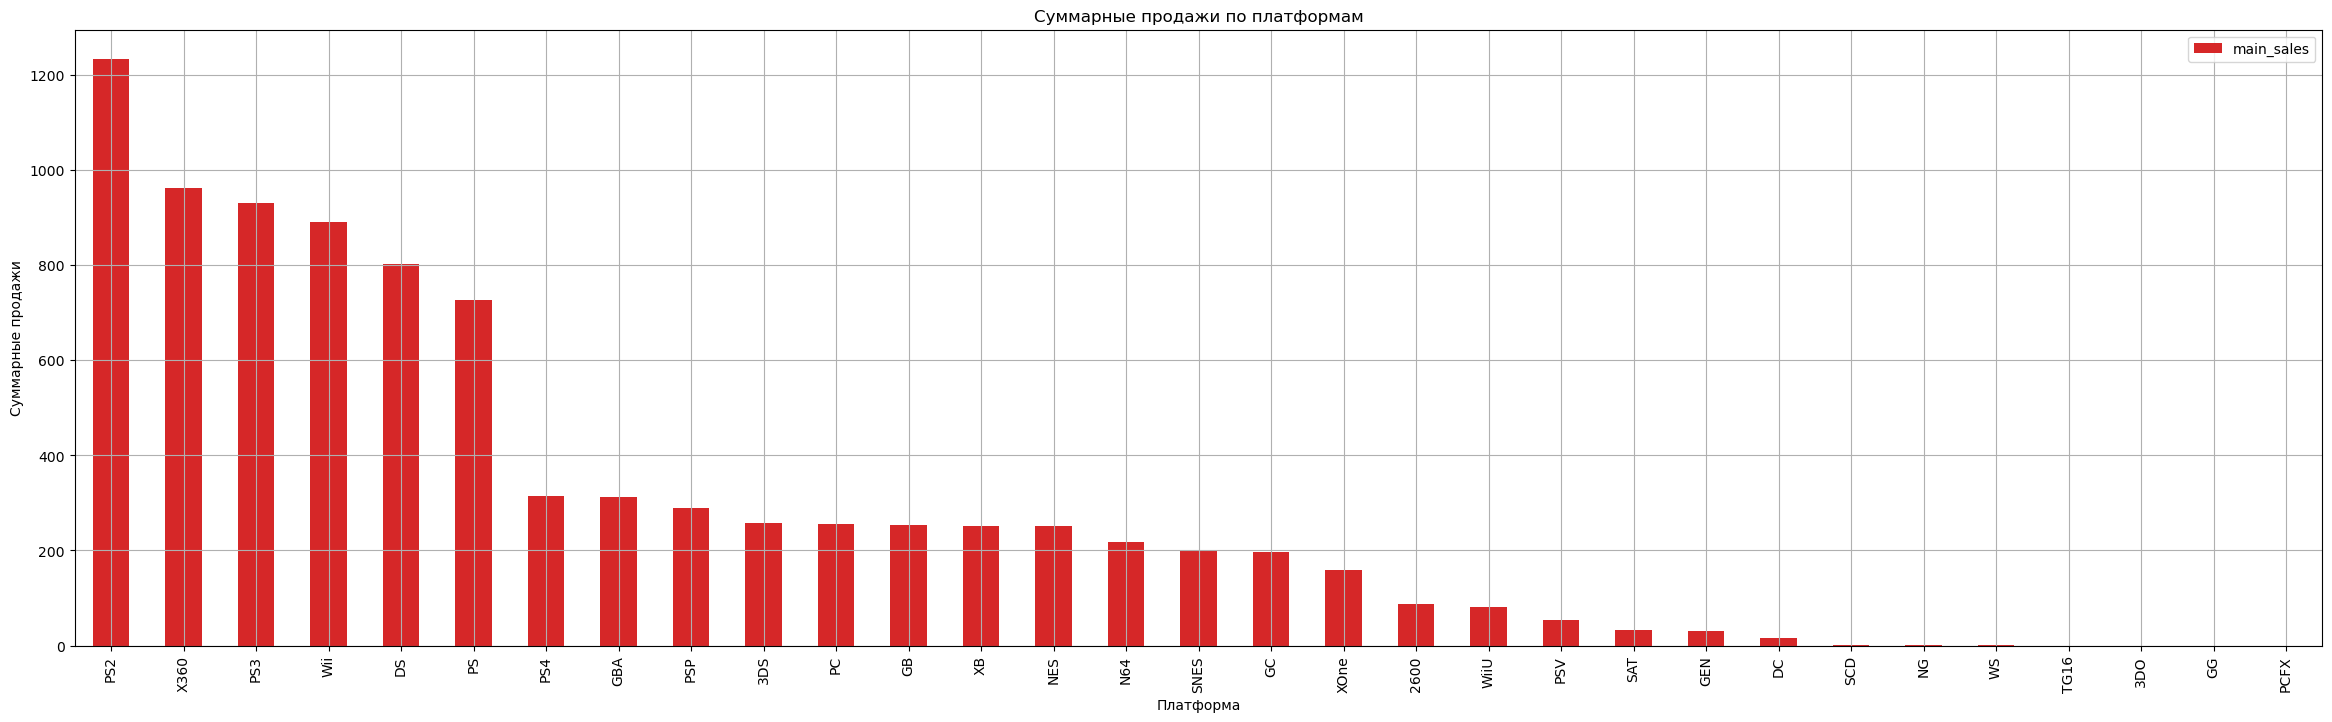

In [15]:
top_platform = data.pivot_table(index = "platform", values = "main_sales" , aggfunc = "sum")
top_platform = top_platform.sort_values(by = "main_sales" , ascending = False)
top_platform.plot(kind = 'bar', figsize = (29,8), grid = True, color='tab:red')
plt.title('Суммарные продажи по платформам')
plt.xlabel("Платформа")
plt.ylabel("Суммарные продажи")
plt.show()

Достаточно большой разрыв между PS и PS4, здесь предлагаю провести границу.

#### Фильтрую таблицу по платформам.

In [16]:
top_platform = data.query("platform in ('PS2', 'Wii', 'PS3', 'X360', 'DS', 'PS')")

#### Изучаю распределение по годам.

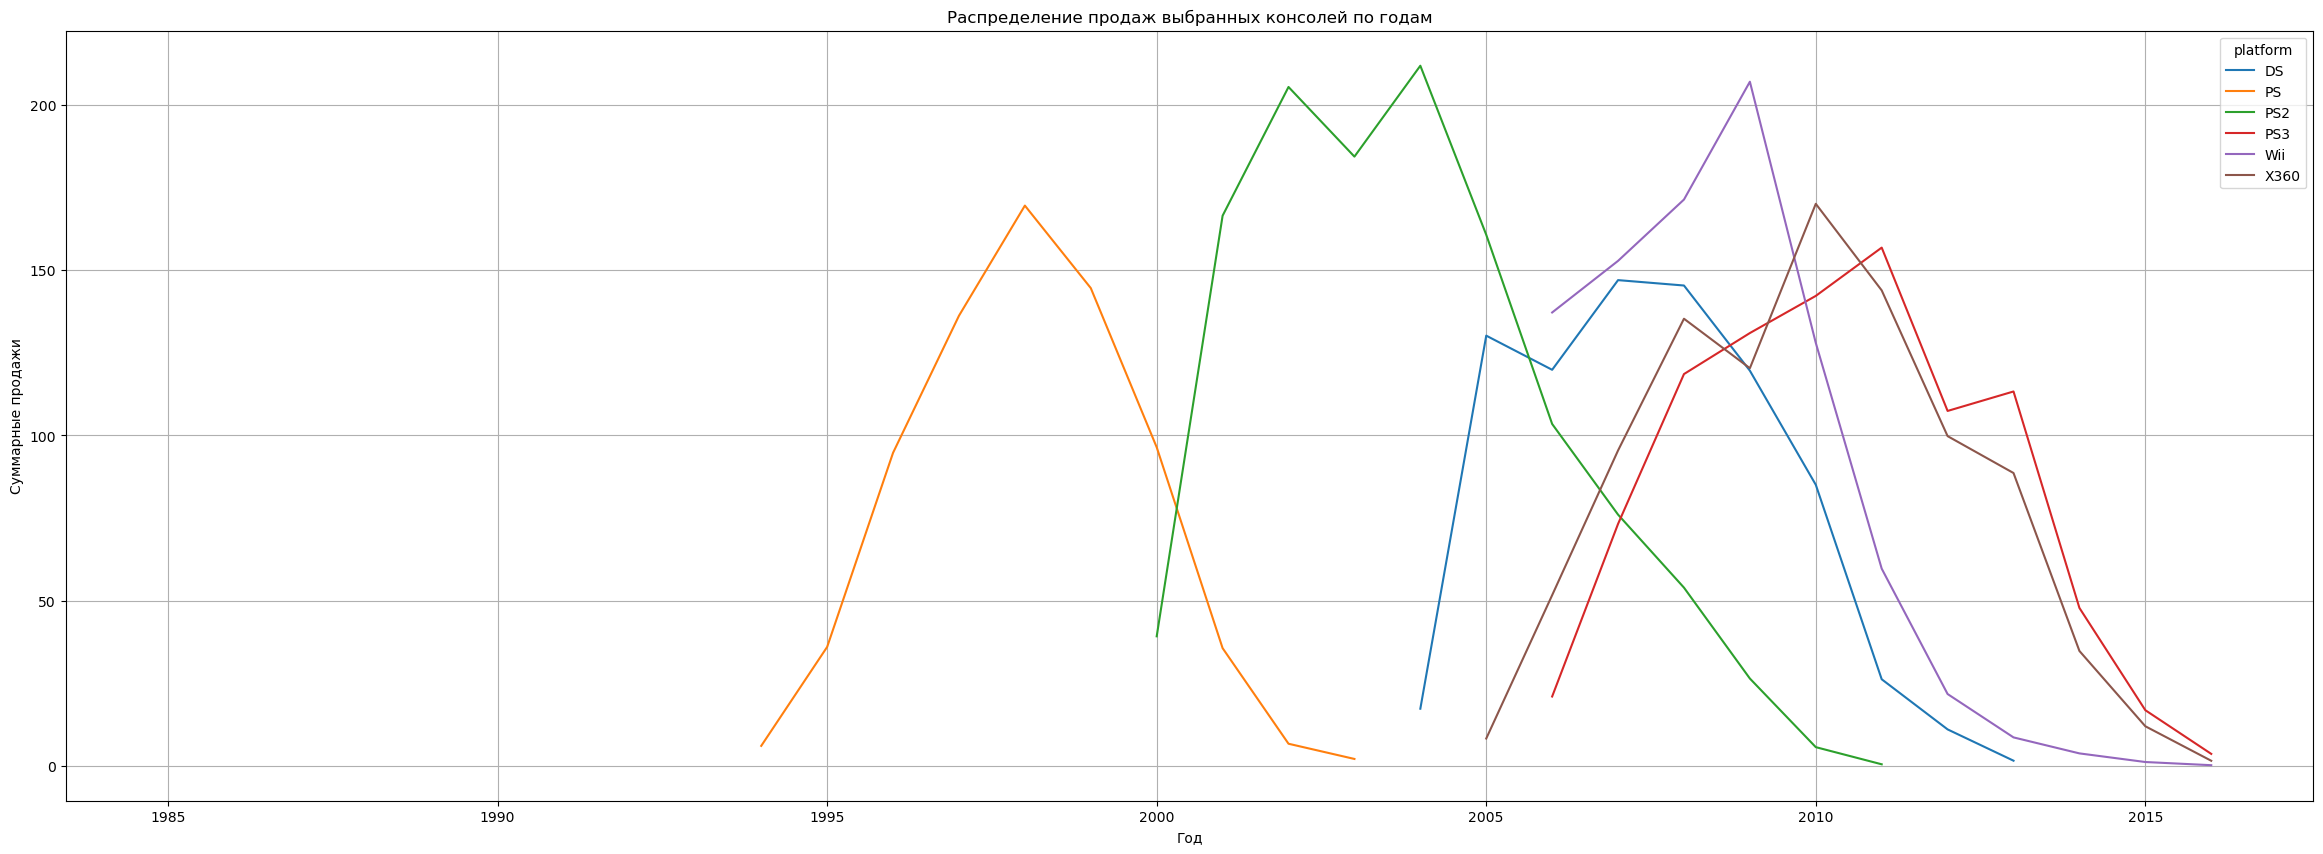

In [17]:
top_platform_pivot = top_platform.pivot_table(index = "year_of_release" ,columns = "platform", values = "main_sales" , aggfunc = "sum")
top_platform_pivot.plot(figsize = (29,10), grid = True)
plt.title('Распределение продаж выбранных консолей по годам')
plt.xlabel("Год")
plt.ylabel("Суммарные продажи")
plt.show()

Пиковые продажи консолей в среднем приходятся на 5-6 лет. Продолжительность жизни консоли практически не превышает 10 лет. Консоли попали в рейтинг потому, что каждая из них полностью прошла цикл от начала продаж до фактического конца.

#### Для прогноза продаж на следующий год возьму данные за последние 5 лет, все, что начало продаваться до 2012 года, будет в продаже уже более 5 лет, что является концом продаж для любых консолей

In [18]:
data = data.query("year_of_release > 2012")

#### Посмотрю на состояние продаж для выбранного периода

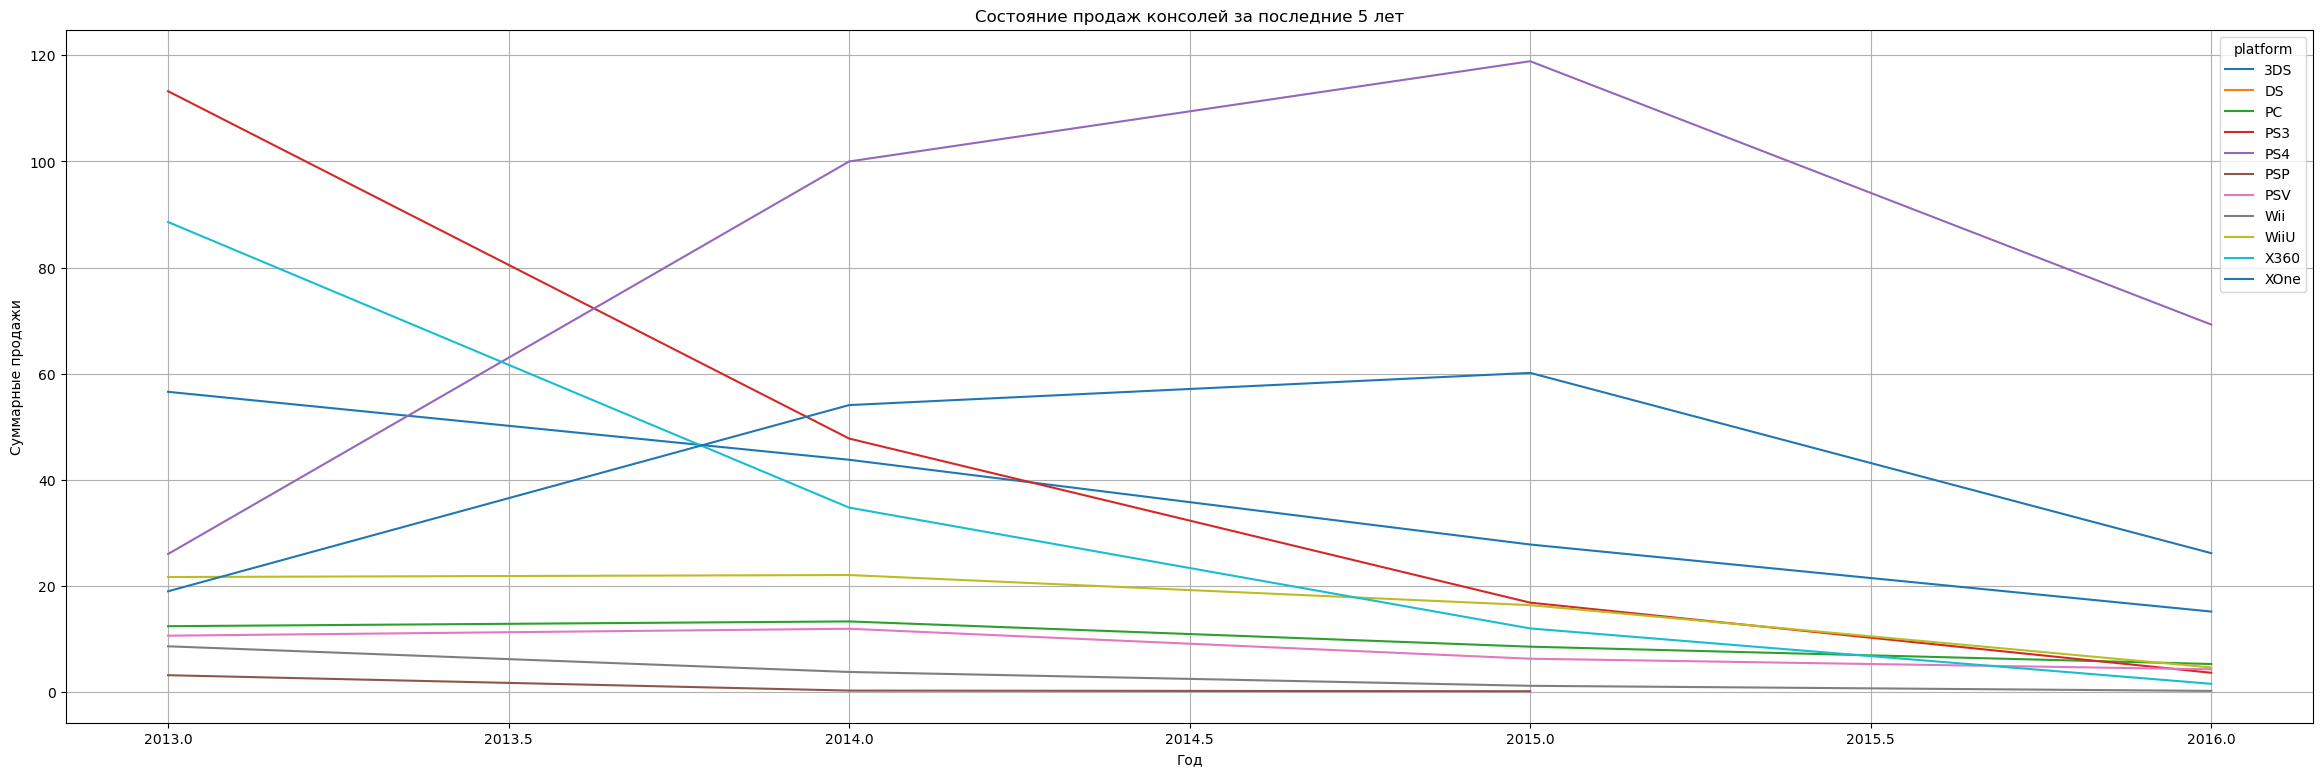

In [19]:
pivot = data.pivot_table(index = "year_of_release" ,columns = "platform", values = "main_sales" , aggfunc = "sum")
pivot.plot(figsize = (29,9), grid = True)
plt.title('Состояние продаж консолей за последние 5 лет')
plt.xlabel("Год")
plt.ylabel("Суммарные продажи")
plt.show()

- Судя по данному графику, продажи всех консолей имеют отрицательную динамику. Есть две консоли, вышедшие относительно недавно (в 2013 году) - это PS4 и 3DS. Их продают всего 3 года, у них наибольшие шансы пойти на повышение продаж.Также можно выделить XOne как одну из лидеров продаж на 2016 год.
- Судя по графику, продажи для нашей тройки лидеров очень стремительно идут вниз. Если данные за 2016 год не полные, продажи, конечно, могут превысить показатели 2015 года, но на данный момент они на минимальных уровнях за все время продаж. Можно предположить, что продажи покажут рост, если данных за 2016 практически нет.

#### Построю "Ящик с усами" для данных консолей с ограничением по оси y

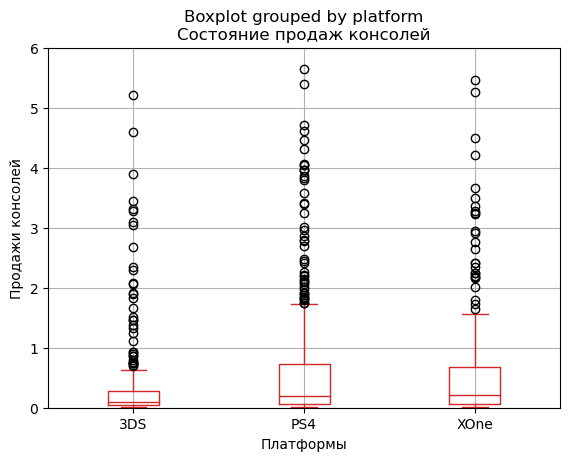

In [20]:
data_new = data.query("platform in ('PS4', '3DS', 'XOne')")
data_new.boxplot(column = "main_sales" , by = "platform", color='tab:red')
plt.ylim(0,6)
plt.title('Состояние продаж консолей')
plt.xlabel("Платформы")
plt.ylabel("Продажи консолей")
plt.show()

#### Построю "Ящик с усами" для данных консолей без ограничения по оси у, чтобы оценить выбросы

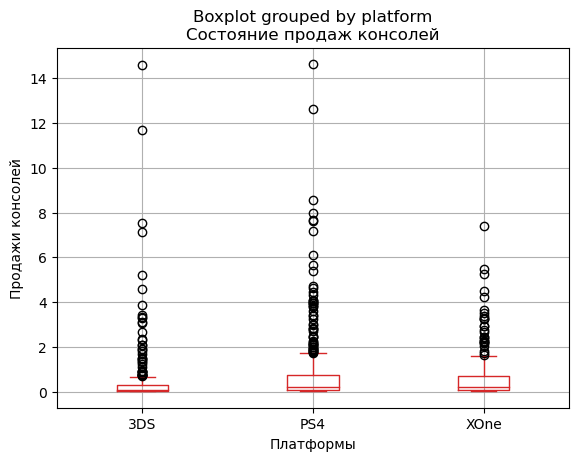

In [21]:
data_new.boxplot(column = "main_sales" , by = "platform", color='tab:red')
plt.title('Состояние продаж консолей')
plt.xlabel("Платформы")
plt.ylabel("Продажи консолей")
plt.show()

Построил график без ограничений по оси У. Если принять за выбросы значение больше 6 млн продаж, то мы видим, что Xone достаточно стабилен, выбросов практически нет.

Самые большие медианные продажи у PS4 и XOne. Также видно достаточно большой разброс продаж на разные игры, у каждой платформы есть игры с низкими продажи и высокими.

#### Проверю влияние отзывов пользователей и критиков на продажи PS4

In [22]:
ps4 = data.query("platform == 'PS4'")
ps4 = ps4.query("user_score > 0")
print(ps4['main_sales'].corr(data['critic_score']), "Влияние оценки критиков")
print(ps4['main_sales'].corr(data['user_score']), "Влияние оценки игроков")

0.40589480145836687 Влияние оценки критиков
-0.031957110204556424 Влияние оценки игроков


Похоже, что оценки критиков оказывают среднее влияние на продажи игр.

Коэффициент корреляции между глобальными продажами и оценкой пользователей - очень низкий, поэтому выявил отсутствие линейной связи.

#### Построю диаграмму рессеяния для оценок критиков

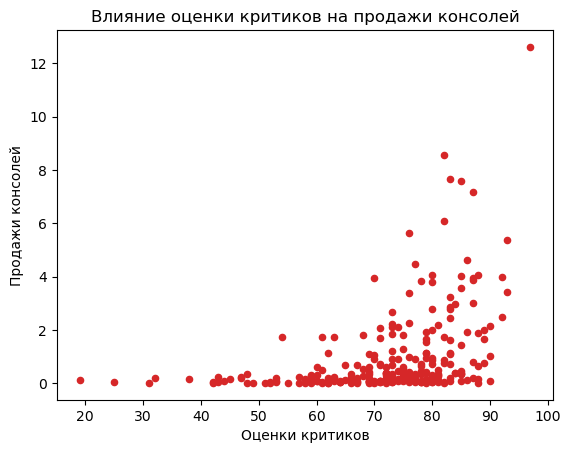

In [23]:
ps4.plot(x='critic_score', y='main_sales', kind='scatter', color='tab:red')
plt.title('Влияние оценки критиков на продажи консолей')
plt.xlabel("Оценки критиков")
plt.ylabel("Продажи консолей")
plt.show()

На диаграмме хорошо видно, что чем выше оценка критика, тем больше продажи у игры.

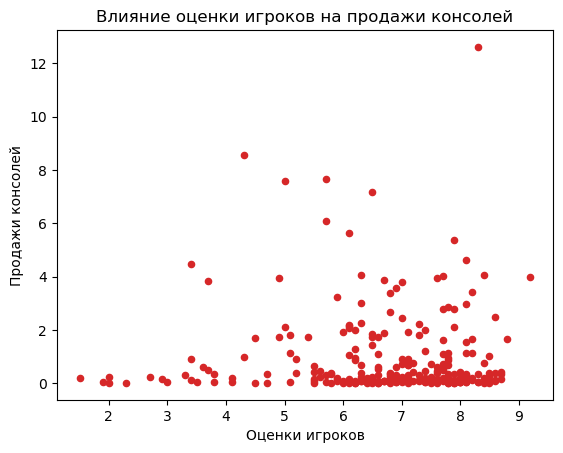

In [24]:
ps4.plot(x='user_score', y='main_sales', kind='scatter', color='tab:red')
plt.title('Влияние оценки игроков на продажи консолей')
plt.xlabel("Оценки игроков")
plt.ylabel("Продажи консолей")
plt.show()

Основная тенденция также - чем выше оценка, тем больше продажи. Однако, я вижу больше выбросов, достаточно много игр имеет низкую оценку от игроков, при этом игра показывает большие продажи.

#### Попробую посмотреть на те же параметры, взяв все платформы, кроме PS4

In [25]:
not_ps4 = data.query("platform != 'PS4'")
not_ps4 = not_ps4.query("user_score > 0")
print(not_ps4['main_sales'].corr(data['critic_score']), "Влияние оценки критиков")
print(not_ps4['main_sales'].corr(data['user_score']), "Влияние оценки игроков")

0.27874941770382183 Влияние оценки критиков
-0.0011216242093378518 Влияние оценки игроков


Разрыв в корреляции между оценками критиков и игроков примерно одинаковый.

#### Посмотрю на диаграммы рассеяния

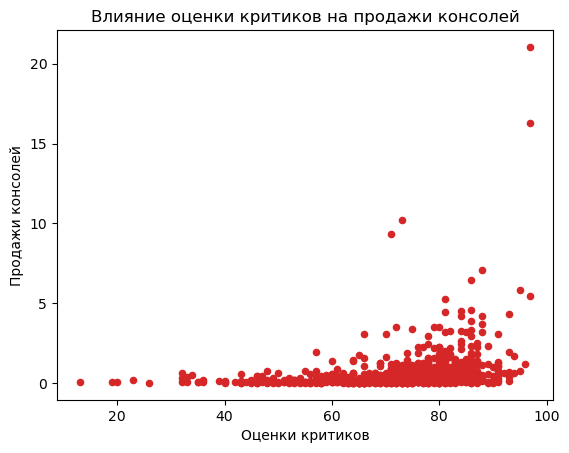

In [26]:
not_ps4.plot(x='critic_score', y='main_sales', kind='scatter', color='tab:red')
plt.title('Влияние оценки критиков на продажи консолей')
plt.xlabel("Оценки критиков")
plt.ylabel("Продажи консолей")
plt.show()

Диаграмма похожа на прошлую, чем выше оценка, тем больше продажи.

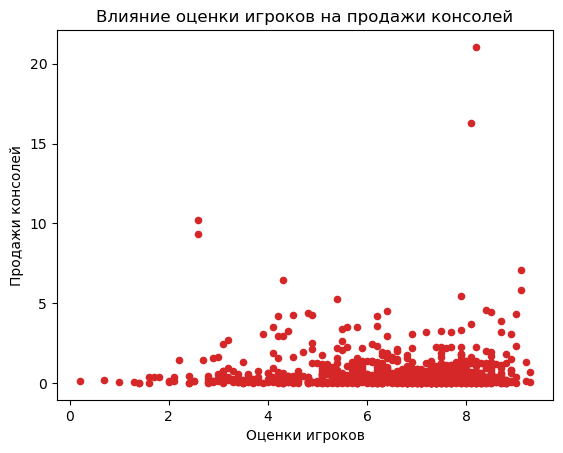

In [27]:
not_ps4.plot(x='user_score', y='main_sales', kind='scatter', color='tab:red')
plt.title('Влияние оценки игроков на продажи консолей')
plt.xlabel("Оценки игроков")
plt.ylabel("Продажи консолей")
plt.show()

В целом, та же закономерность - чем выше оценка, тем больше продажи. Однако, тут диаграмма больше сосредоточена на середине, достаточно много игр со средней оценкой имеют высокие продажи.

### Посмотрю на распределение игр по жанрам

#### Выделю самые прибыльные жанры и посмотрю на жанры с самыми низкими продажами

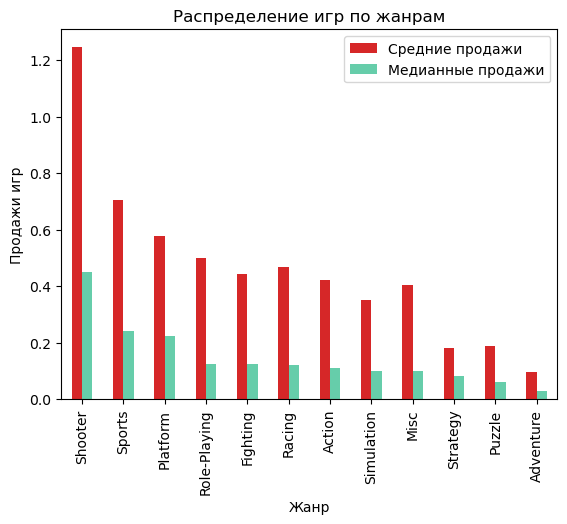

In [28]:
top_genre = data.pivot_table(index = "genre", values = "main_sales" , aggfunc = ("mean", "median"))
top_genre = top_genre.sort_values(ascending = False, by = "median")
top_genre.plot(kind = 'bar', color= ('tab:red', '#66CDAA'))
plt.title('Распределение игр по жанрам')
plt.xlabel("Жанр")
plt.ylabel("Продажи игр")
plt.legend(['Средние продажи', 'Медианные продажи'])
plt.show()

Вижу достаточно большой разрыв в продажах: жанры шутер, спорт и платформеры - явные лидеры продаж. Жанры стратегии, паззлы и приключения явно уступают всем остальным.

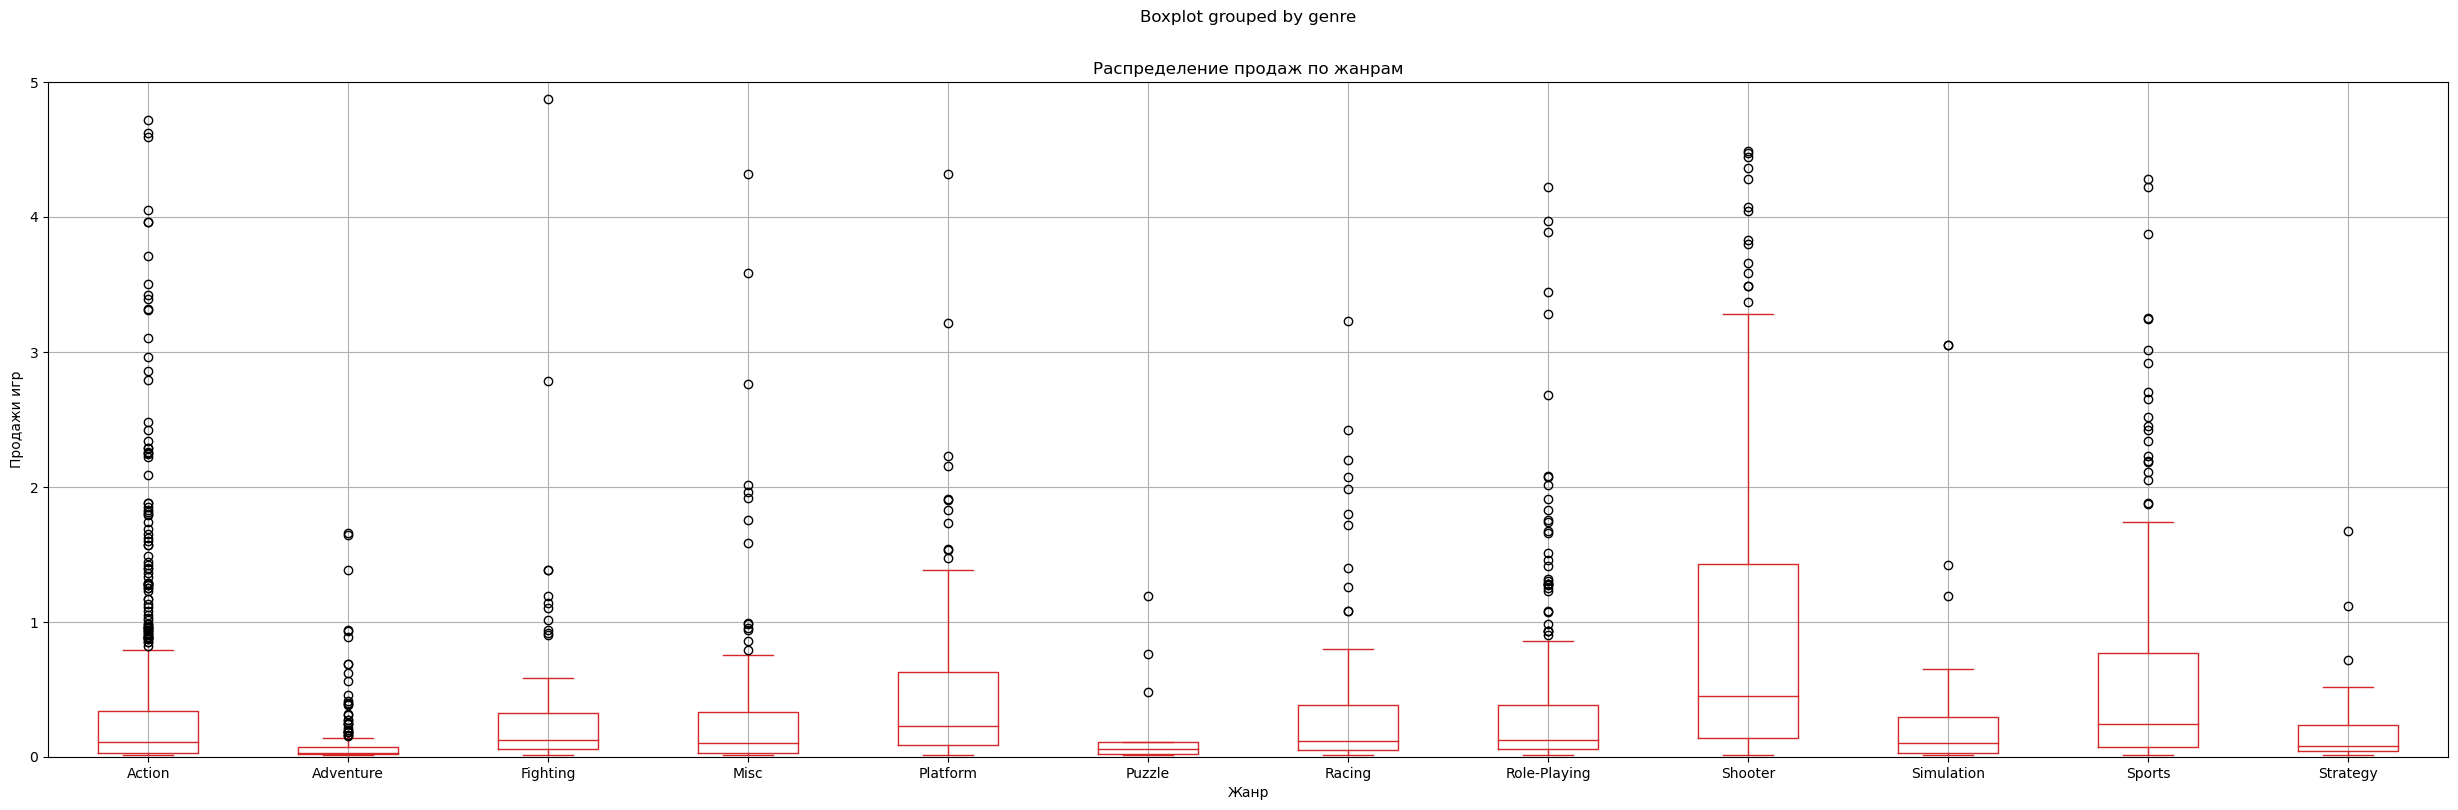

In [29]:
data.boxplot(column = "main_sales" , by = "genre", figsize=(30,9), color='tab:red')
plt.ylim(0,5)
plt.title('Распределение продаж по жанрам')
plt.xlabel("Жанр")
plt.ylabel("Продажи игр")
plt.show()

"Ящик с усами" показывает распределение по жанрам и подтверждает вывод выше.

### Составление портрета пользователя каждого региона

#### Изучу северную Америку - NA. Топ 5 платформ и жанров игр, также рассмотрю влияние оценки ESRB на продажи

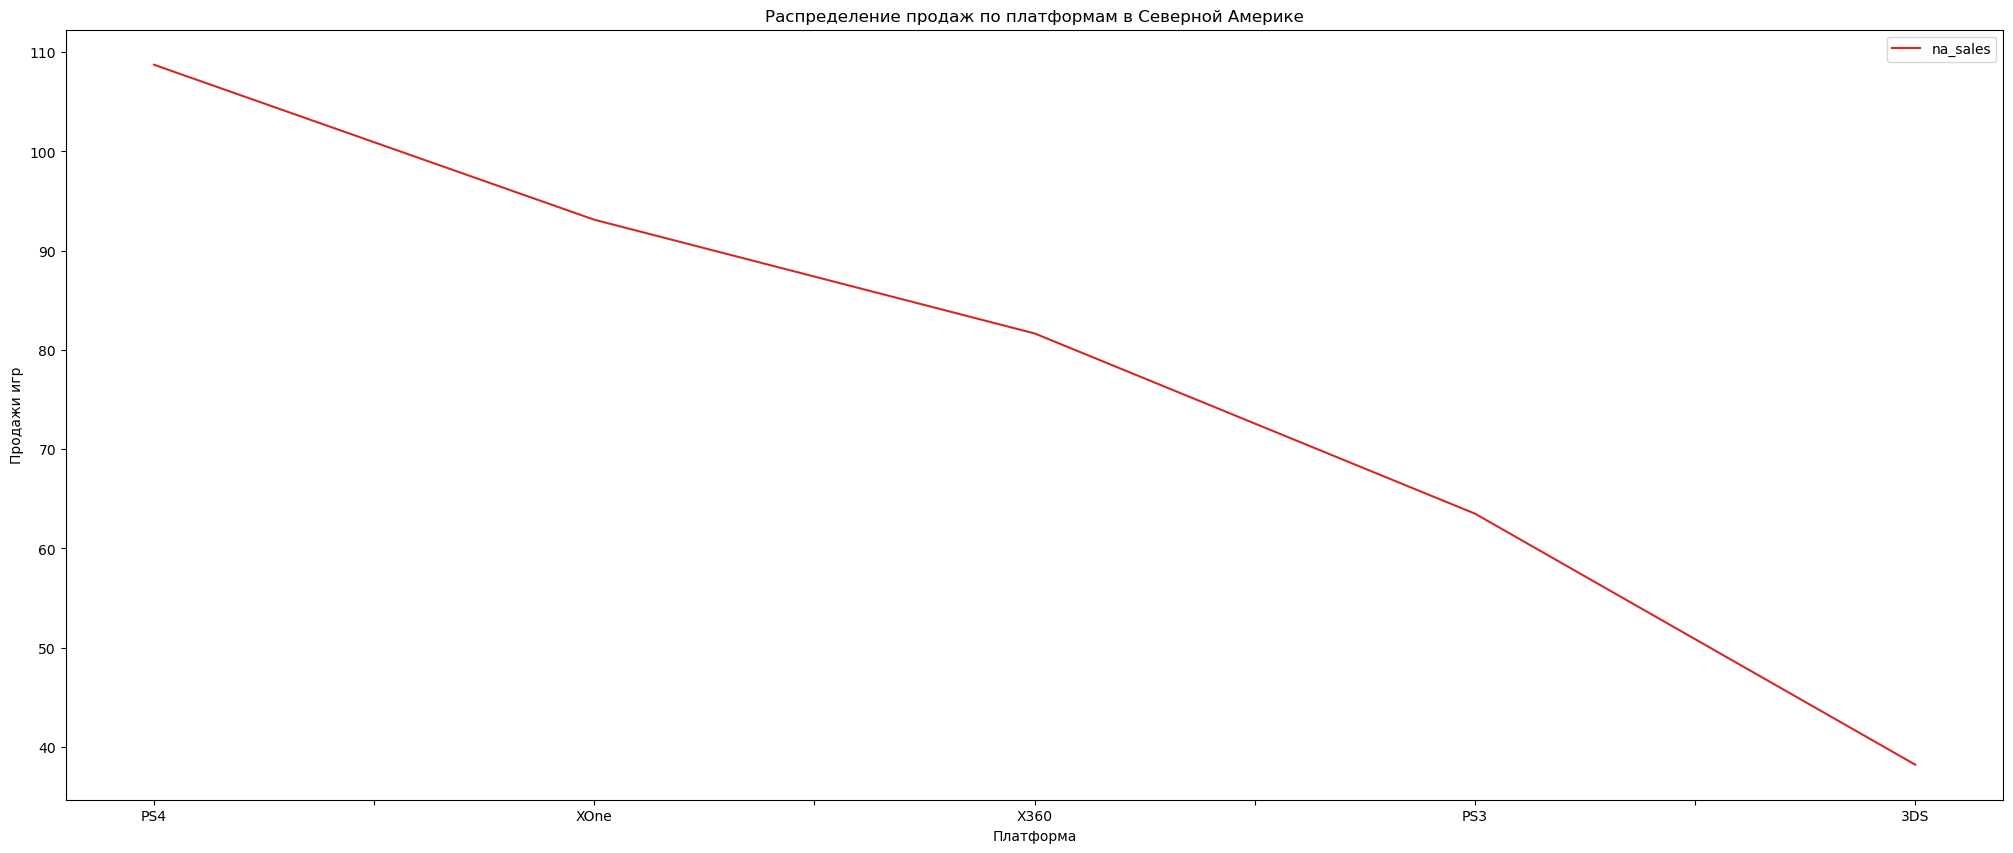

In [30]:
na_sales = data.pivot_table(index = "platform" , values = "na_sales", aggfunc = "sum")
na_sales.sort_values(by = "na_sales", ascending = False).head(5).plot(color='tab:red', figsize = (25,10))
plt.title('Распределение продаж по платформам в Северной Америке')
plt.xlabel("Платформа")
plt.ylabel("Продажи игр")
plt.show()

Нашел топ 5 платформ по продажам в Северной Америке, лидирует PS4. На последнем месте 3DS.

#### Нахожу топ жанров игр

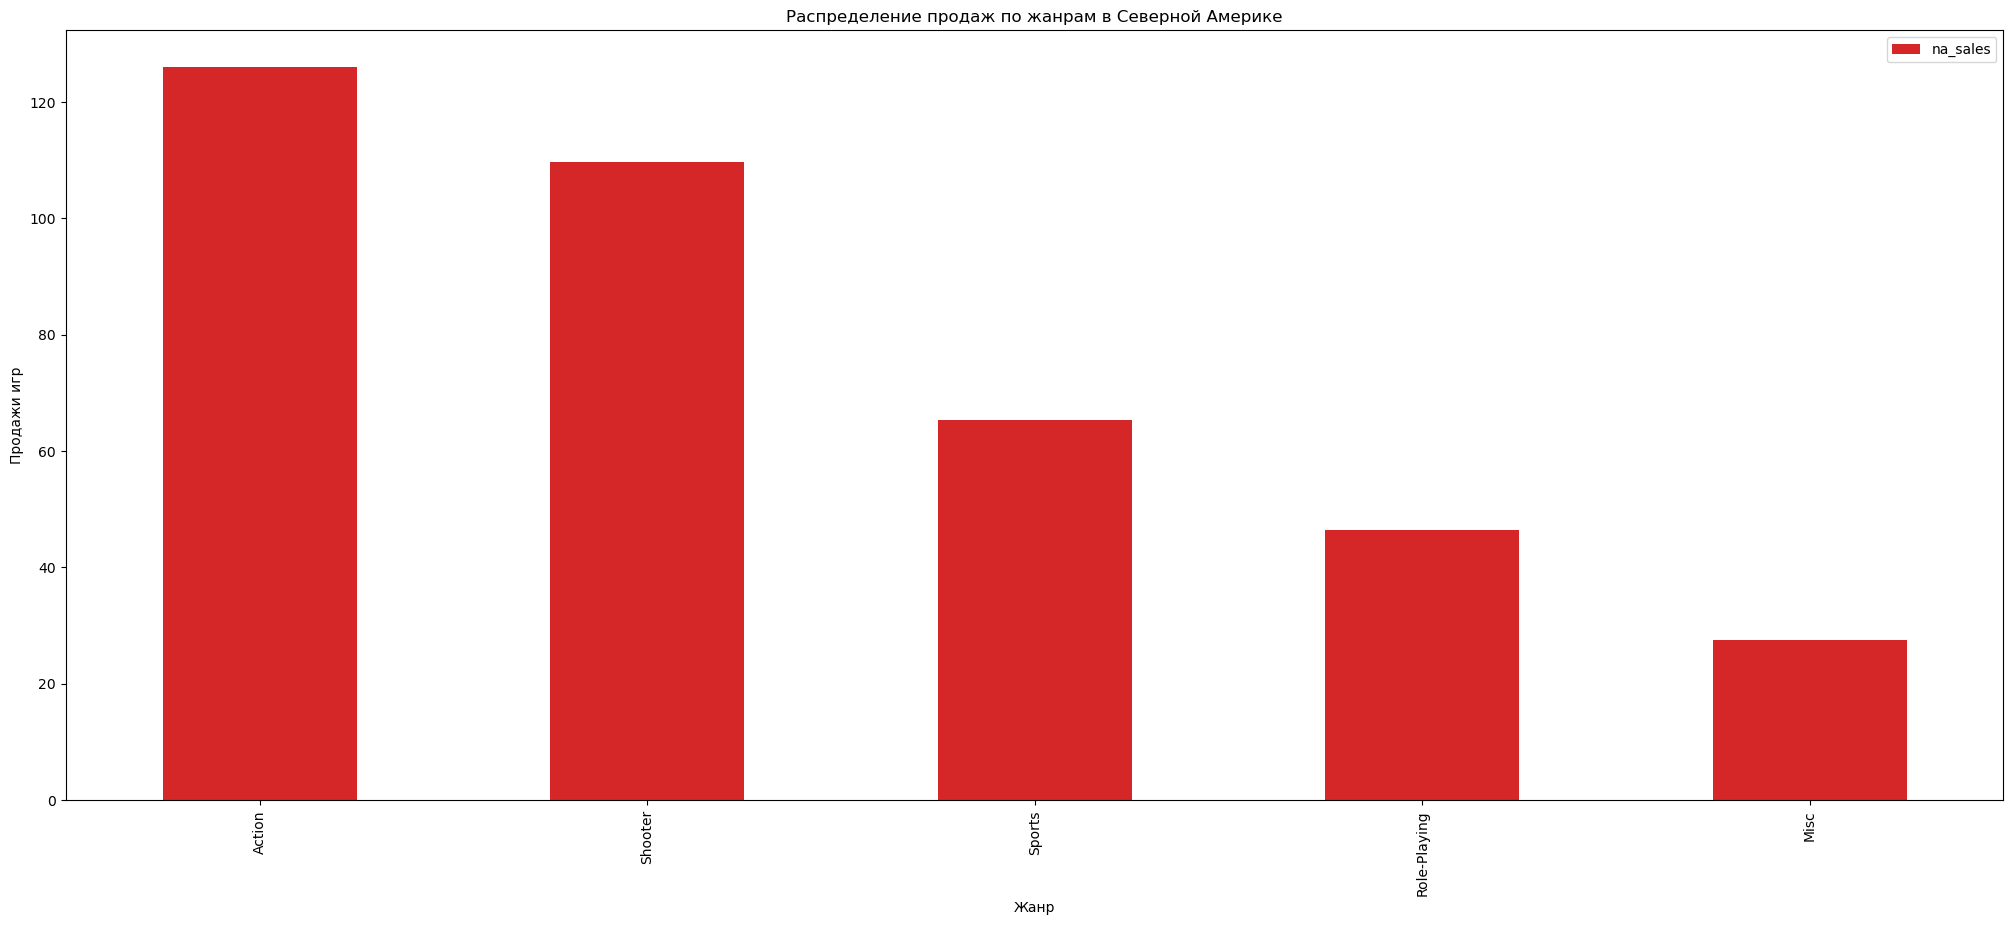

In [31]:
na_sales = data.pivot_table(index = "genre" , values = "na_sales", aggfunc = "sum")
na_sales = na_sales.sort_values(by = "na_sales", ascending = False).head(5).plot(kind = 'bar', color='tab:red', figsize = (25,10))
plt.title('Распределение продаж по жанрам в Северной Америке')
plt.xlabel("Жанр")
plt.ylabel("Продажи игр")
plt.show()

Нашел топ 5 жанров, лидирует экшн. На последнем месте - аркадный жанр.

#### Оценю влияние оценки ESRB (возрастного рейтинга) на продажи игр

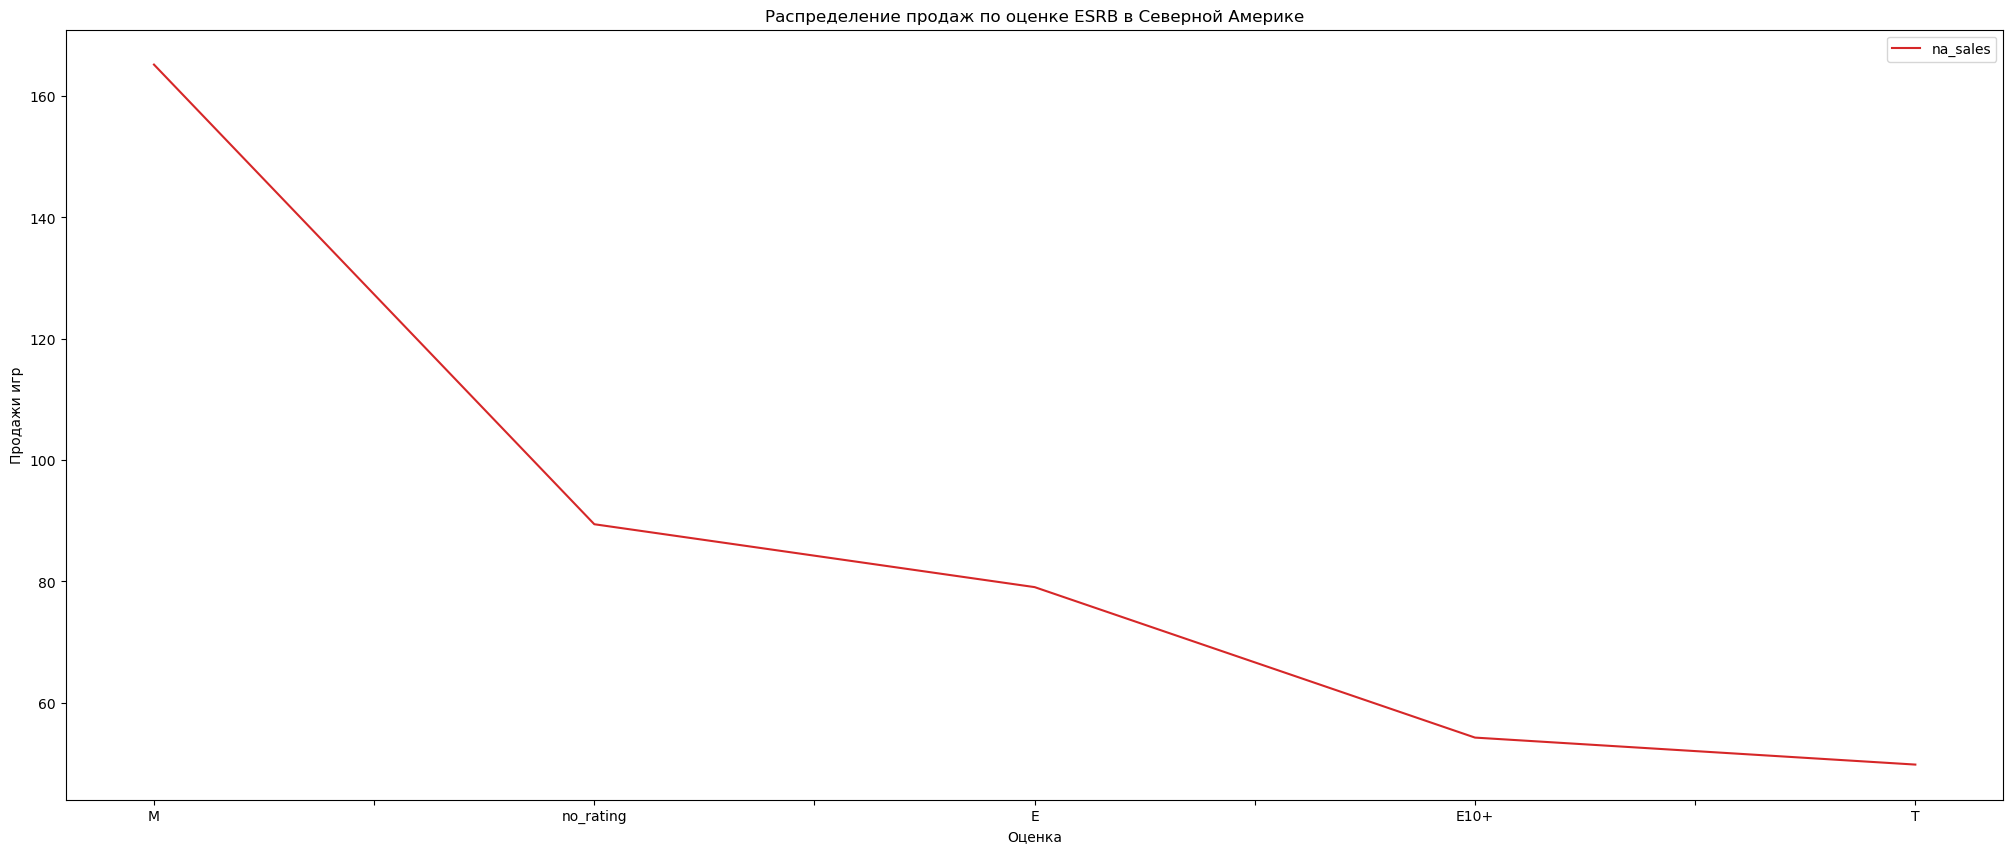

In [32]:
na_sales = data.pivot_table(index = "rating" , values = "na_sales", aggfunc = "sum")
na_sales.sort_values(by = "na_sales", ascending = False).plot(color='tab:red', figsize = (25,10))
plt.title('Распределение продаж по оценке ESRB в Северной Америке')
plt.xlabel('Оценка')
plt.ylabel('Продажи игр')
plt.show()

Игры без рейтинга были учтены. Скорее всего, эти игры подходят для всех возрастов, в том числе для детей.

Лидер продаж - рейтинг М (17+). Остальные рейтинги примерно в равной степени разделили оставшийся рынок. 

#### Теперь проверю теже параметры для европейского рынка

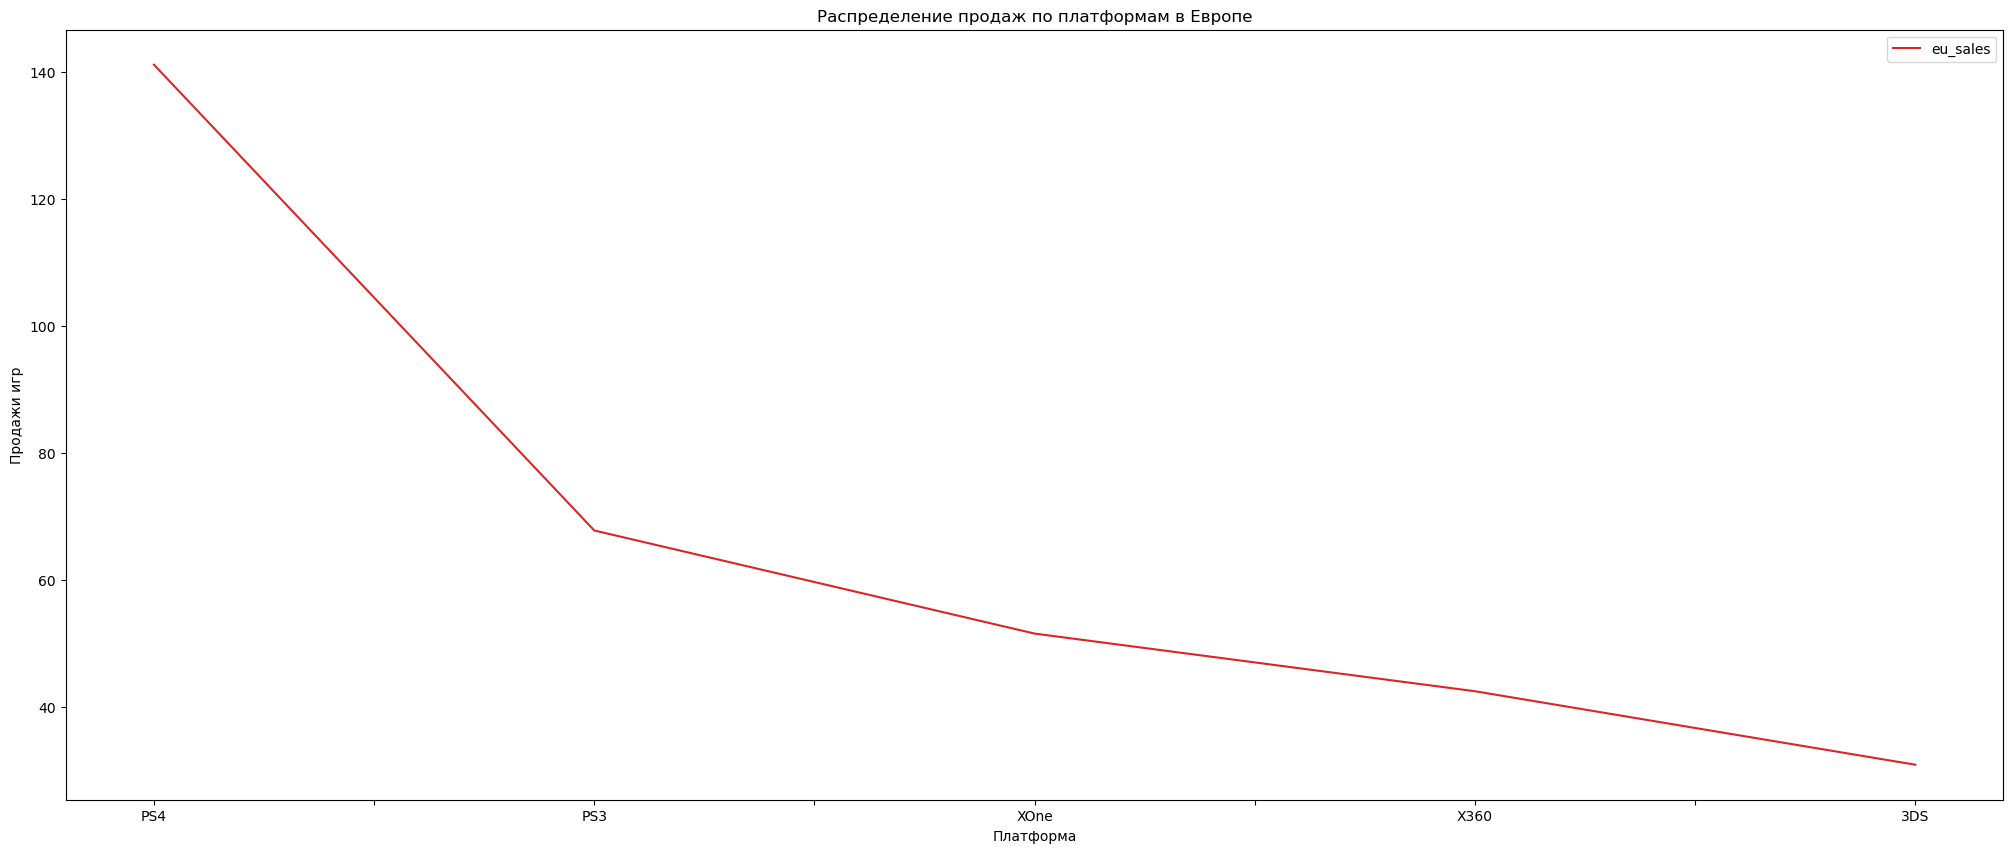

In [33]:
eu_sales = data.pivot_table(index = "platform" , values = "eu_sales", aggfunc = "sum")
eu_sales.sort_values(by = "eu_sales", ascending = False).head(5).plot(color='tab:red', figsize = (25,10))
plt.title('Распределение продаж по платформам в Европе')
plt.xlabel("Платформа")
plt.ylabel("Продажи игр")
plt.show()

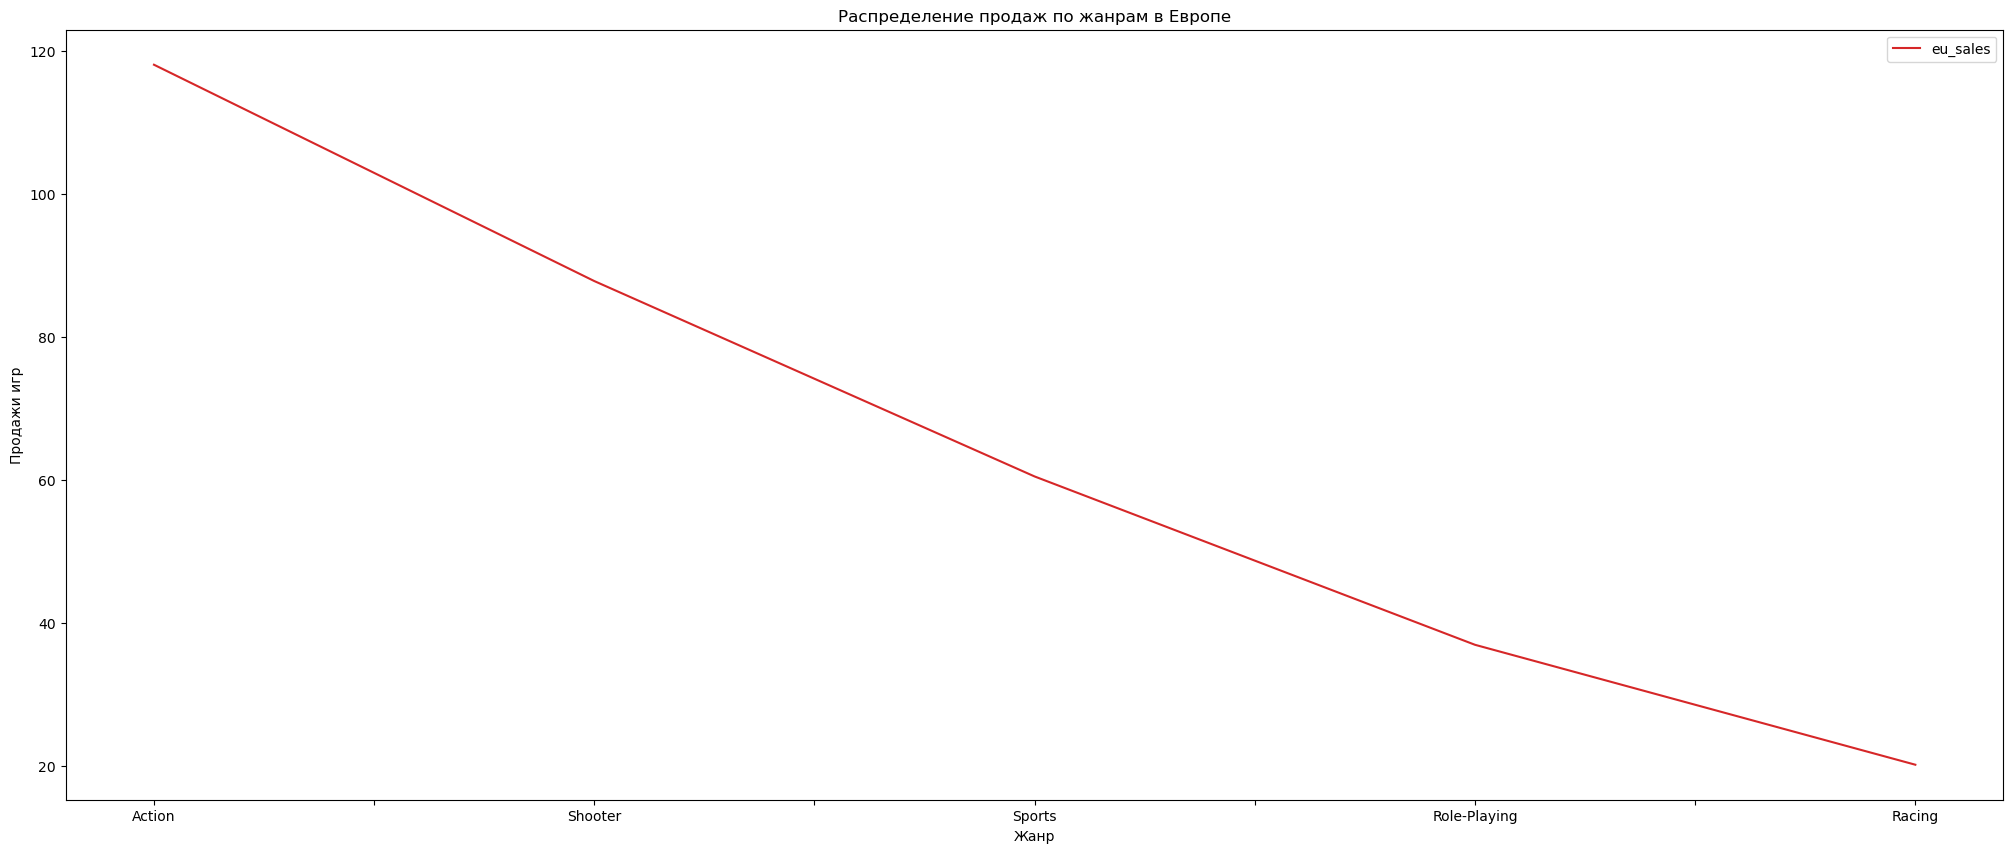

In [34]:
eu_sales = data.pivot_table(index = "genre" , values = "eu_sales", aggfunc = "sum")
eu_sales.sort_values(by = "eu_sales", ascending = False).head(5).plot(color='tab:red', figsize = (25,10))
plt.title('Распределение продаж по жанрам в Европе')
plt.xlabel("Жанр")
plt.ylabel("Продажи игр")
plt.show()

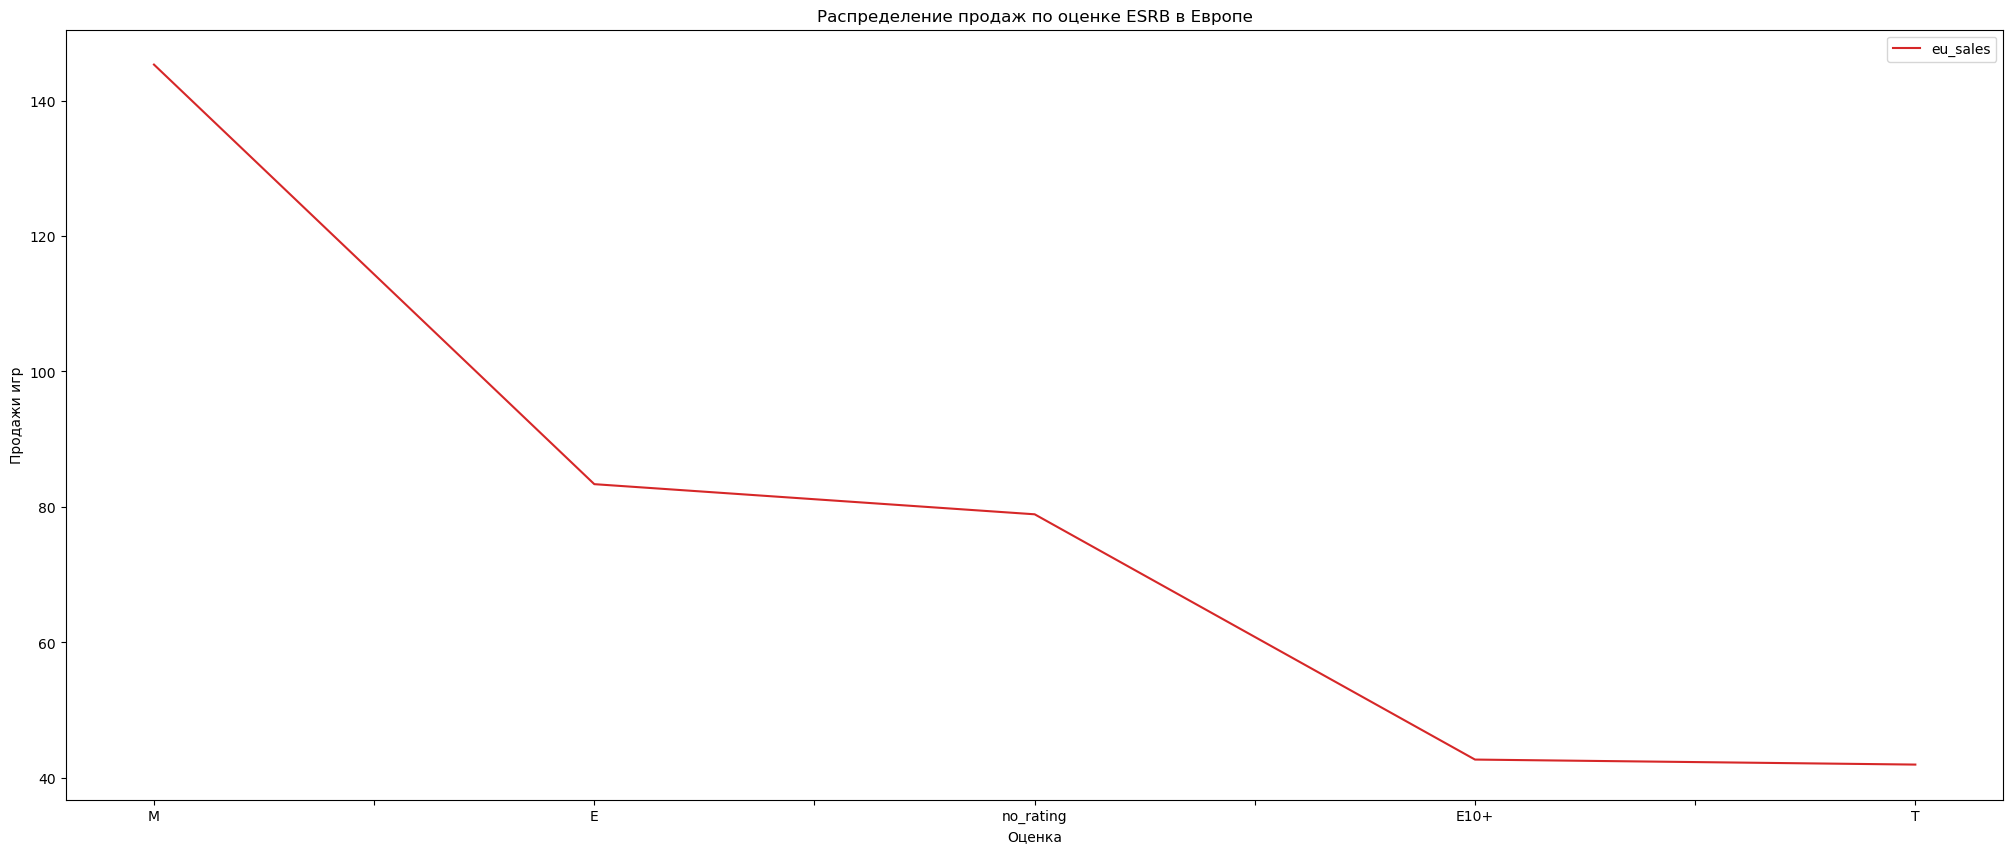

In [35]:
eu_sales = data.pivot_table(index = "rating" , values = "eu_sales", aggfunc = "sum")
eu_sales.sort_values(by = "eu_sales", ascending = False).plot(color='tab:red', figsize = (25,10))
plt.title('Распределение продаж по оценке ESRB в Европе')
plt.xlabel("Оценка")
plt.ylabel("Продажи игр")
plt.show()

- Любимая платформа в Европе - японская Playstation. Занимает первое и второе место. На последнем месте - 3DS.
- Любимый жанр в Европе - Экшн, на послднем месте гонки.
- Самые продаваемые игры - с возрастным рейтингом М, так же, как и в Америке.

#### Также посмотрю на Японию

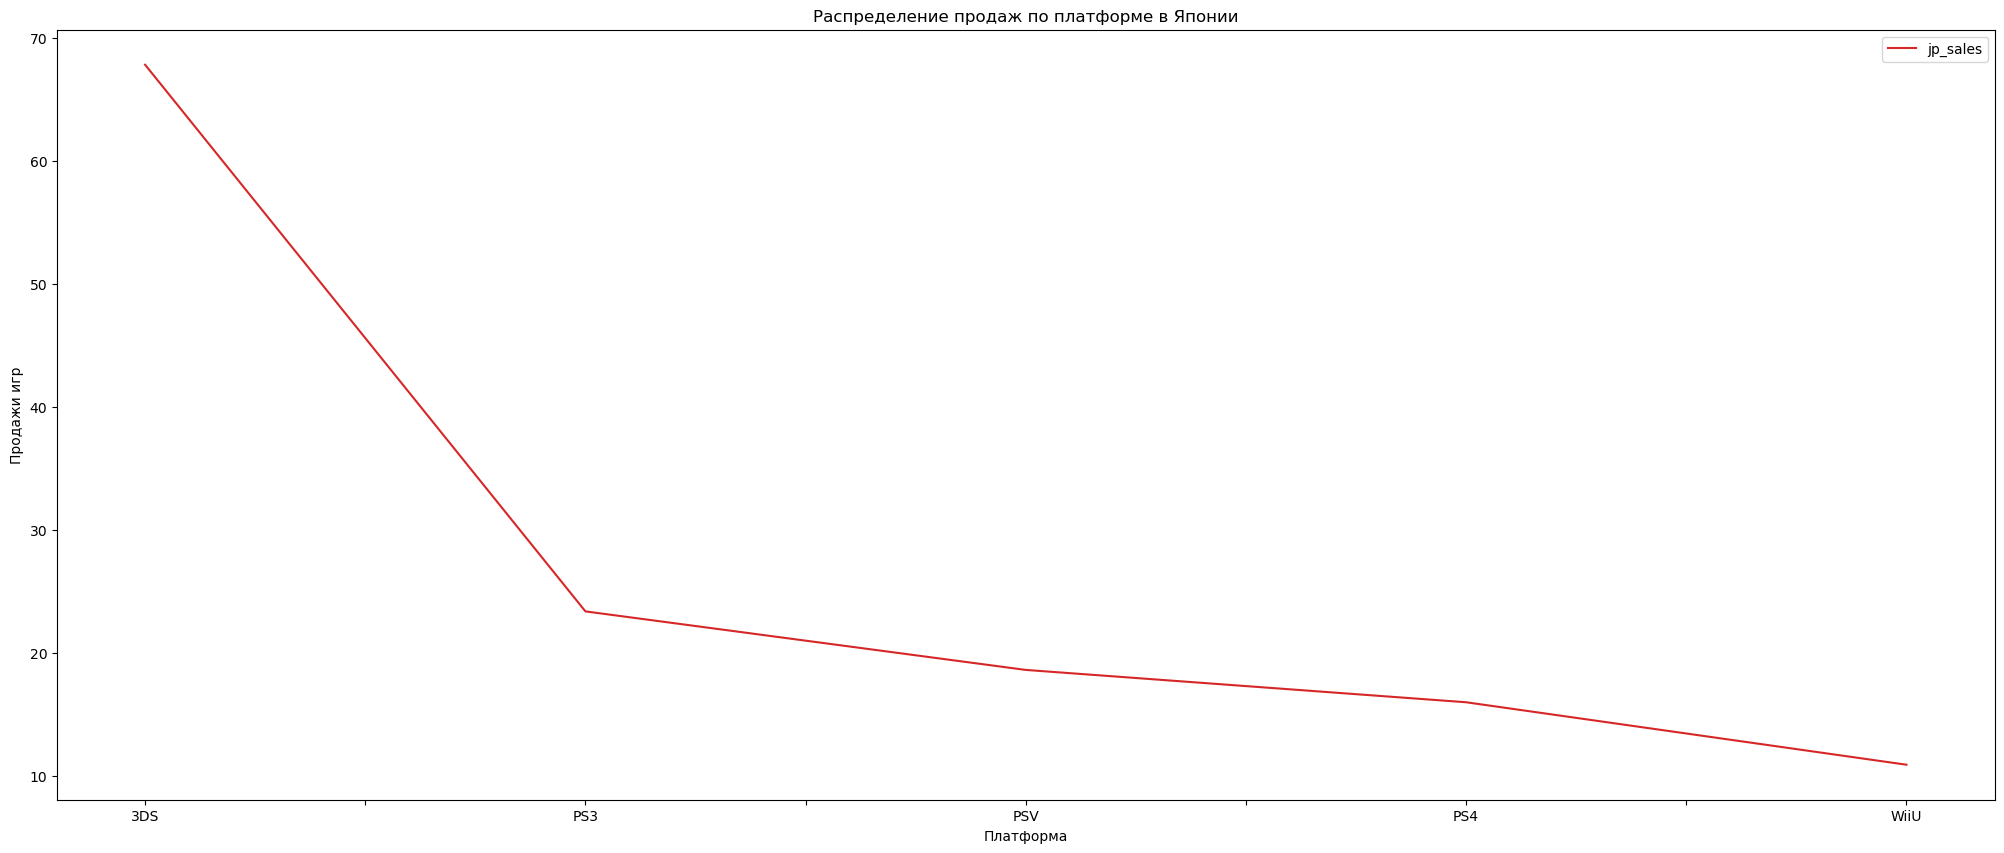

In [36]:
jp_sales = data.pivot_table(index = "platform" , values = "jp_sales", aggfunc = "sum")
jp_sales.sort_values(by = "jp_sales", ascending = False).head(5).plot(color='tab:red', figsize = (25,10))
plt.title('Распределение продаж по платформе в Японии')
plt.xlabel("Платформа")
plt.ylabel("Продажи игр")
plt.show()

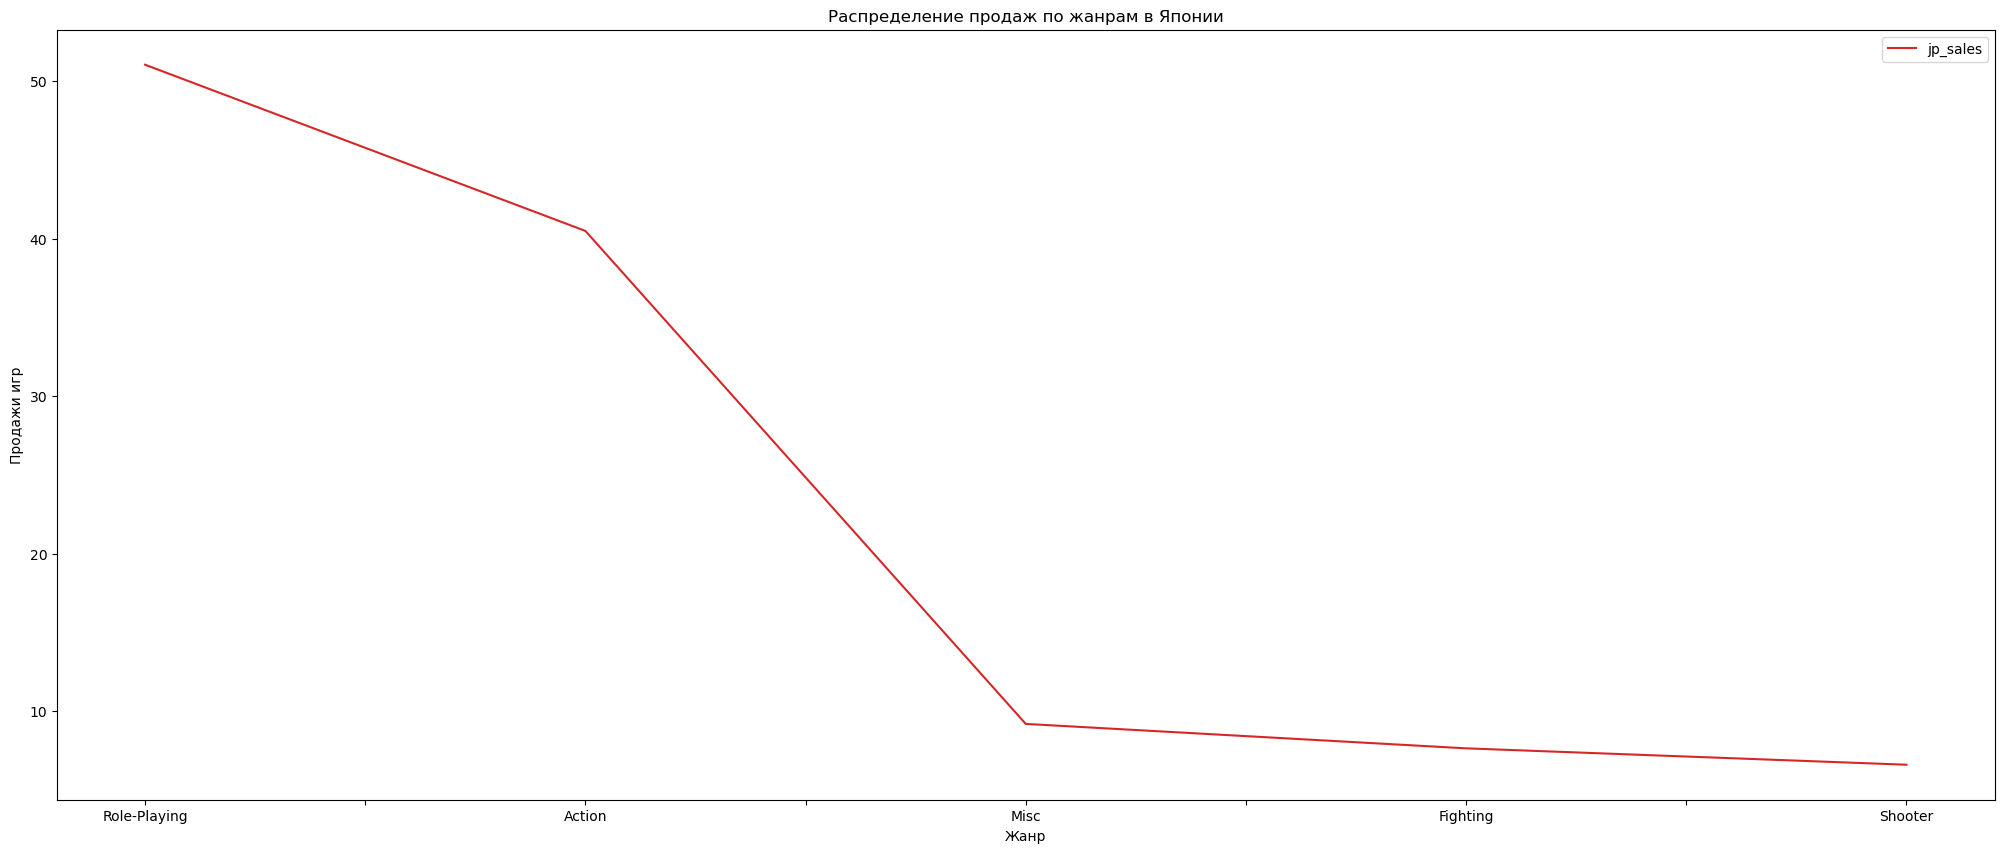

In [37]:
jp_sales = data.pivot_table(index = "genre" , values = "jp_sales", aggfunc = "sum")
jp_sales.sort_values(by = "jp_sales", ascending = False).head(5).plot(color='tab:red', figsize = (25,10))
plt.title('Распределение продаж по жанрам в Японии')
plt.xlabel("Жанр")
plt.ylabel("Продажи игр")
plt.show()

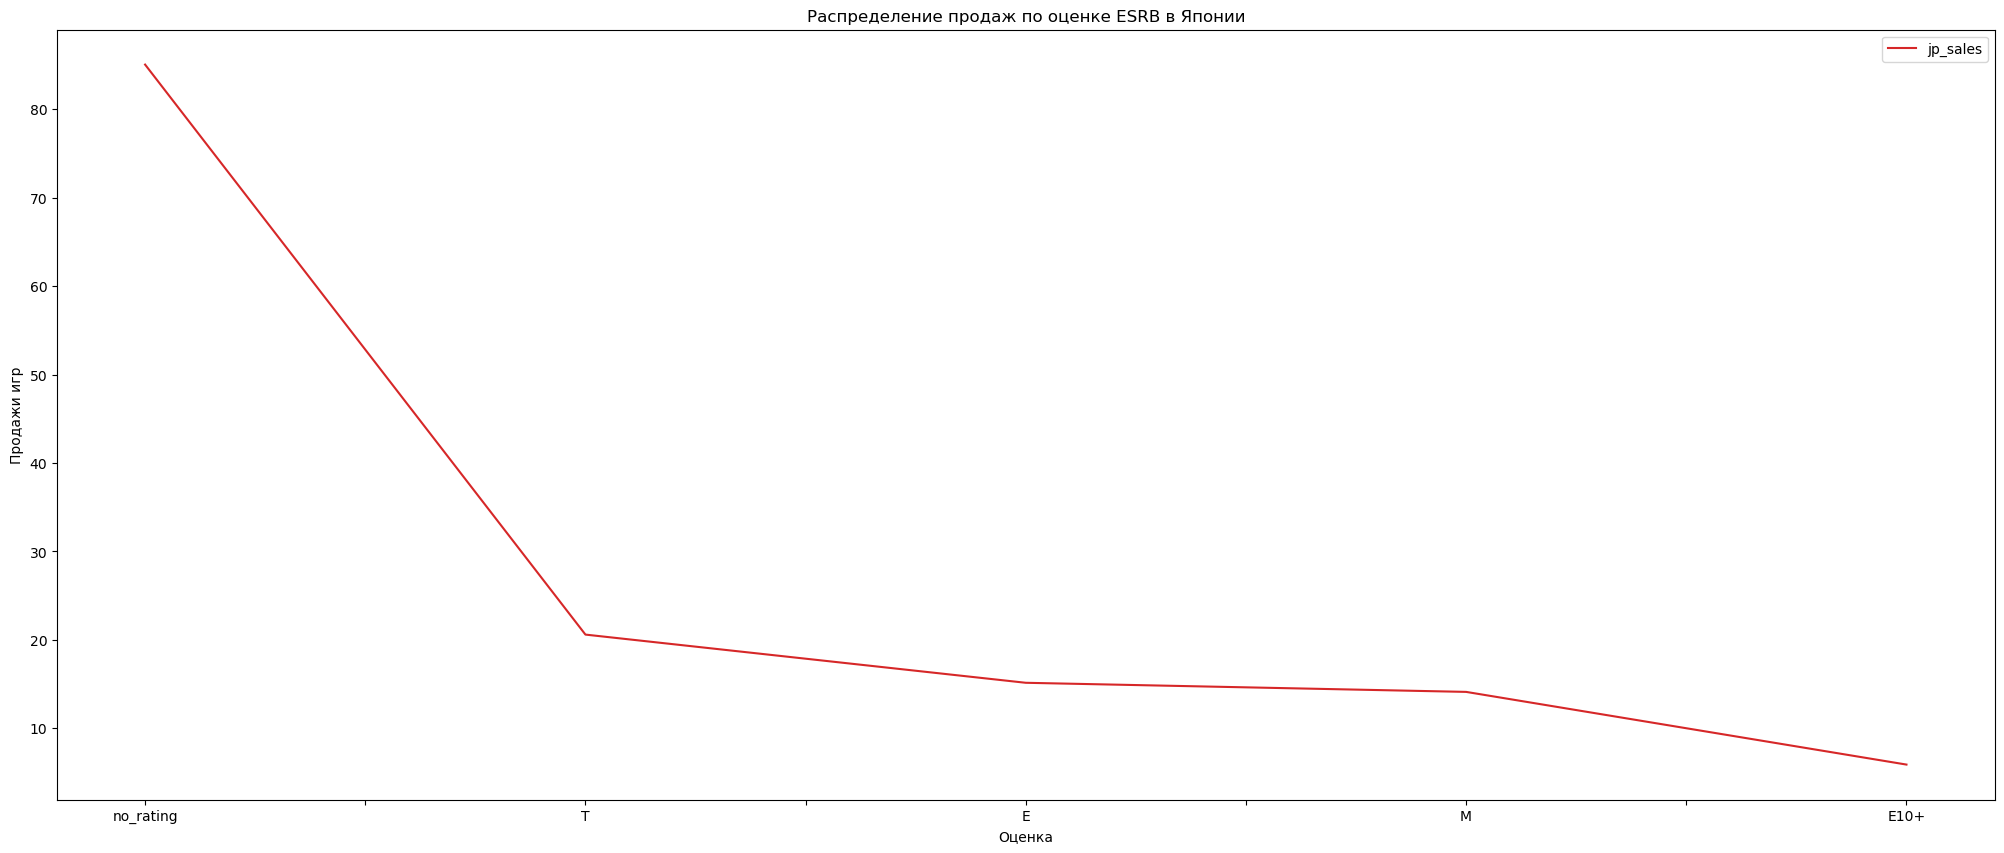

In [38]:
jp_sales = data.pivot_table(index = "rating" , values = "jp_sales", aggfunc = "sum")
jp_sales.sort_values(by = "jp_sales", ascending = False).plot(color='tab:red', figsize = (25,10))
plt.title('Распределение продаж по оценке ESRB в Японии')
plt.xlabel("Оценка")
plt.ylabel("Продажи игр")
plt.show()

Япония показывает совсем другие данные.
- Любимая платформа японцев - 3DS, последняя Wii.
- Любимый жанр - ролевые игры, шутер на последнем месте.
- Самые продаваемые игры - без рейтинга. Возможно, в Японии любят играть в семейные игры для всех возрастов.

## Проверка гипотез

### Гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Сформулирую нулевую и альтернативную гипотезы:

Нулевая: средние пользовательские рейтинги равны.

Альтернаятивна: средние пользовательские рейтинги не равны.

Возьму уровень статистической значимости 0.05

In [39]:
#Применю гипотезу о равенстве двух средних генеральных совокупностей, данные выборки независимые
sample1 = data.dropna(subset = ["user_score"])
sample1 = sample1.query("user_score > 0")
sample1 = sample1.query("platform == 'XOne'")
sample1 = sample1["user_score"]
sample2 = data.dropna(subset = ["user_score"])
sample2 = sample2.query("platform == 'PC'")
sample2 = sample2["user_score"]
results = st.ttest_ind(sample1, sample2)
aplpha = 0.05
print(results.pvalue, "р-value")
if results.pvalue < aplpha:
    print("Не удалось подтвердить гипотезу")
else:
    print("Гипотеза может быть верна")

0.016705862656063167 р-value
Не удалось подтвердить гипотезу


Коэффициент получился ниже статистической значимости, средние рейтинги платформ почти всегда разные, я не могу подтвердить гипотезу.

### Гипотеза: средние пользовательские рейтинги жанров экшн и спорт разные

Сформулирую нулевую и альтернативную гипотезы:

Нулевая: средние пользовательские рейтинги не равны.

Альтернаятивна: средние пользовательские рейтинги равны.

Возьму уровень статистической значимости 0.05

In [40]:
#Применю гипотезу о равенстве двух средних генеральных совокупностей, данные выборки независимые
sample1 = data.dropna(subset = ["user_score"])
sample1 = sample1.query("genre == 'Action'")
sample1 = sample1["user_score"]
sample2 = data.dropna(subset = ["user_score"])
sample2 = sample2.query("genre == 'Sports'")
sample2 = sample2["user_score"]
results = st.ttest_ind(sample1, sample2)
aplpha = 0.05
print(results.pvalue, "р-value")
if results.pvalue < aplpha:
    print("Гипотеза может быть верна")
else:
    print("Не удалось подтвердить гипотезу")


1.0163952264107545e-09 р-value
Гипотеза может быть верна


P-значение гораздо меньше статистической значимости, значит, можно утверждать, что пользовательские рейтинги для данных жанров координально отличаются.

## Общий вывод

- Ознакомился с изначальными данными, обнаружил пропуски в данных и неверные форматы данных.
- Названия столбцов привел к нижнему регистру.
- Заменил пропуски в столбце "Имя".
- Удалил все строки с пропусками в столбце "Год издания" и перевел в формат int.
- Заменил пропуски в столбце "Жанр".
- В столбце "Оценка игрока" перевел оценку tbd в числовой формат и перевел в формат int.
- Посчитал суммарные продажи игр во всех регионах и добавил в новый столбец.

Исследовательский анализ данных

- Изучил, сколько игр выпускалось в разные годы. Определил, что до 1993 года в год выпускалось менее 100 игр, самое большое кол-во игр выходило с 2005 по 2010 год.
- Нашел платформы с наибольшими суммарными продажами. Самые большие продажи за все время показали PS2, X360, PS3, Wii, DS и PS. 
- Проверил распределение по годам продажи данных консолей. Определил, что пиковые продажи консолей длятся в среднем 5-6 лет. В среднем консоль продается около 10 лет.
- Для анализа продаж на следующий год отбросил консоли, вышедшие более 5 лет назад, так как в следующие года их продажи будут только падать. Анализируем консоли вышедшие после 2012 года.
- Построил график продаж для консолей выбранного периода. В целом, все приставки показывают отрицательную динамику продаж. Определил 3 консоли, показывающих наивысшие продажи в последний год - это PS4, 3DS и Xone.
- Построил распределение для 3 лучших по продажам консолей "Ящик с усами". Определили, что медианные продажи выше у PS4 и XOne. У каждой из данных платформ достаточно большой разброс по продажам игр, некоторые показывают низкие продажи, некоторые - достаточно большие.
- Проверил влияние отзывов пользователей и критиков на продажи. Определил, что отзывы критиков в средней степени влияют на продажи игр, отзывы пользователей в среднем не влияют на продажи.
- Выделил самые прибыльные игровые жанры. "Шутеры", "спортивные" и "платформеры" возглавляют топ продаж. "Стратегии", "паззлы" и "приключения" оказались самыми непопулярными жанрами.
- Составил портрет пользователя из Северной Америки. Это игроки, в основном играющие на PS4 и XOne, они любят "экшены" и "шутеры", основной играющий контингент - больше 17 лет.
- Составил портрет пользователя из Европы. Это игроки, в основном играющие на PS4, они также любят "экшены" и "шутеры", основной возрастной контингент - больше 17 лет. Игроки из Северной Америки и Европы достаточно похожи.
- Составил портрет японского игрока. Это игроки, в основном играющие на 3DS в ролевые и экшн игры, без определенного возрастного рейтинга. Данный регион достаточно сильно отличается от остальных, к нему нужен отдельный подход.

Проверил гипотезу, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые. За нулевую гипотезу принял, что оценки для обеих платформ равны, вторая гипотеза - что не равны. При уровне статистической значимости в 0.05 получил р-значение в 0.01, что говорит о том, что гипотеза не верна. Средние рейтинги данных платформ почти всегда различаются.

- Проверил гипотезу, что средние пользовательские рейтинги жанров "экшн" и "спорт" разные. За нулевую гипотезу принял, что средние оценки равны, за альтернативную гипотезу - что не равны. При уровне статистической значимости в 0.05 получил р-значение в примерное 0.001, что говорит о том, что почти во всех случаях оценки различаются. Гипотезу считаю подтвержденной.

Исходя из данных, делаю вывод, что продажи всех уже вышедших консолей в следующем году продолжат снижаться при сохранении текущих темпов. Все они вышли достаточно давно, прошли пики своих продаж и насытили рынок. В следующем году опять же лучшие продажи будут у PS4 и XОne. Также могу предположить, что в следующем году должна появиться новая платформа, которая должна показать хорошие продажи. 